In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import importlib
from model.fasterrcnn import *
from model.advattack import *
from data_utils.utils import *
from data_utils.arraytools import *

import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Model

In [3]:
model = load_Faster_RCNN(backbone='resnet18')

model.to(device)

checkpoint = torch.load('./saved_models/fasterrcnn_resnet18_2021-04-12_final.pth')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

## Testing

In [4]:
test_img_list, test_bboxes = wider_read(limit_images=None, train=False)

test_dataset = WiderDataset(test_img_list, test_bboxes)

test_loader = DataLoader(test_dataset,
                         batch_size=1,
                         shuffle=True,
                         num_workers=0,
                         collate_fn=collate_fn
                         )

In [17]:
start = time.time()

prediction_info = []
target_info = []
model.eval()

for images, targets in test_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        predictions = model(images)
    
    predictions = [{k: v.to('cpu').detach() for k, v in t.items()} for t in predictions]
    targets = [{k: v.to('cpu').detach() for k, v in t.items()} for t in targets]
    prediction_info.append(predictions)
    target_info.append(targets)
    images = list(image.detach() for image in images)
    images.clear()
#     targets.clear()
    torch.cuda.empty_cache()

end = time.time()
print(f"Time elapsed in Predicting: {(end - start)/60:.2f} minutes")
prediction_info = list(itertools.chain(*prediction_info))
target_info = list(itertools.chain(*target_info))

Time elapsed in Predicting: 18.62 minutes


In [18]:
# model.to('cpu')
# torch.cuda.empty_cache()

In [19]:
# importlib.reload(data_utils.arraytools)

In [20]:
results = {}
for i in range(3,11):
    r_temp = evaluation(prediction_info, target_info, iou_thresh=i/10, interpolation_method='EveryPoint')
    results[i/10] = r_temp
    

Processing :  99%|█████████▉| 3119/3135 [00:15<00:00, 191.29it/s]

In [21]:
for thres, result in results.items():
    prec = result['total TP']/(result['total TP'] + result['total FP'])
    rec = result['total TP']/result['total positives']
    print(f"For the Threshold {thres}: \nAverage Precision: {result['AP']:.2f} Total Recall: {rec:.2f}")
#     PlotPrecisionRecallCurve(result)
    print()

For the Threshold 0.3: 
Average Precision: 0.64 Total Recall: 0.70

For the Threshold 0.4: 
Average Precision: 0.63 Total Recall: 0.68

For the Threshold 0.5: 
Average Precision: 0.61 Total Recall: 0.66

For the Threshold 0.6: 
Average Precision: 0.57 Total Recall: 0.62

For the Threshold 0.7: 
Average Precision: 0.49 Total Recall: 0.55

For the Threshold 0.8: 
Average Precision: 0.32 Total Recall: 0.40

For the Threshold 0.9: 
Average Precision: 0.06 Total Recall: 0.16

For the Threshold 1.0: 
Average Precision: 0.00 Total Recall: 0.01



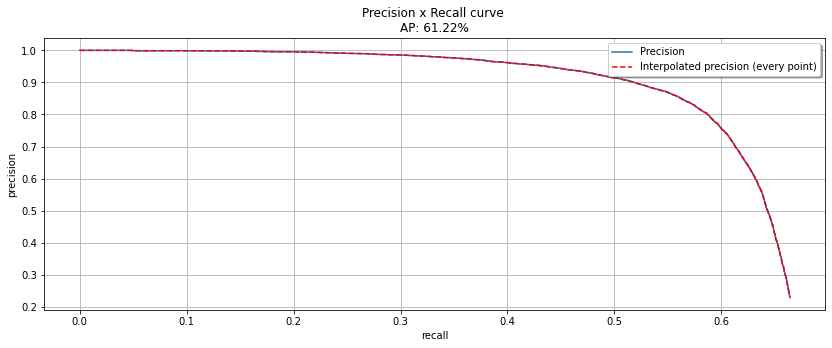

In [22]:
PlotPrecisionRecallCurve(results[0.5])

## Adversarial Attack

In [26]:
detector = PyTorchFasterRCNN(model=model, clip_values=(0, 1), preprocessing=None)
attack = ProjectedGradientDescent(detector, eps=0.01, eps_step=0.01, max_iter=10, verbose=False)

In [27]:
attack_img_list, attack_bboxes = wider_read(limit_images=100, train=False)

attack_dataset = WiderDataset(attack_img_list, attack_bboxes)

attack_loader = DataLoader(attack_dataset,
                         batch_size=1,
                         shuffle=True,
                         num_workers=0,
                         collate_fn=collate_fn
                         )

In [28]:
start = time.time()

adv_image_list = []
prediction_info = []
attack_info = []
target_info = []


with tqdm(attack_loader, unit="image") as t_loader:
    for images, targets in t_loader:

        org_images = list(image.clone().to(device) for image in images)
        attack_images = np.array([tonumpy(image.clone()) for image in images])
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        adv_image = attack.generate(x=attack_images, y=None)
        adv_image_list.append(adv_image[0].copy())
        adv_image = [totensor(adv_image[0].copy()).to(device)]
    #     print('Image Generated')

        model.eval()

        with torch.no_grad():
            org_predictions = model(org_images)
            adv_predictions = model(adv_image)


        org_predictions = [{k: v.to('cpu').detach() for k, v in t.items()} for t in org_predictions]
        adv_predictions = [{k: v.to('cpu').detach() for k, v in t.items()} for t in adv_predictions]
        targets = [{k: v.to('cpu').detach() for k, v in t.items()} for t in targets]

        prediction_info.append(org_predictions)
        attack_info.append(adv_predictions)
        target_info.append(targets)

        org_images = list(image.detach() for image in org_images)
        adv_image = list(image.detach() for image in adv_image)
        org_images.clear()
        adv_image.clear()
        torch.cuda.empty_cache()

pickle.dump(attack_img_list, open('./data/Adver_images/adv_attack_images_1p_40i_100img.p', "wb" ))

end = time.time()
print(f"Time elapsed in Predicting: {(end - start)/60:.2f} minutes")
# adv_image_list = pickle.load( open( "./data/Adver_images/test.p", "rb" ))
prediction_info = list(itertools.chain(*prediction_info))
attack_info = list(itertools.chain(*attack_info))
target_info = list(itertools.chain(*target_info))

100%|██████████| 100/100 [18:44<00:00, 11.24s/image]

Time elapsed in Predicting: 18.74 minutes


In [29]:
r_original = evaluation(prediction_info, target_info, iou_thresh=0.5, interpolation_method='EveryPoint')
r_adversarial_samples = evaluation(attack_info, target_info, iou_thresh=0.5, interpolation_method='EveryPoint')

Processing : 100%|██████████| 100/100 [00:01<00:00, 58.77it/s]


For the original samples : 
Average Precision: 0.51 Total Recall: 0.56


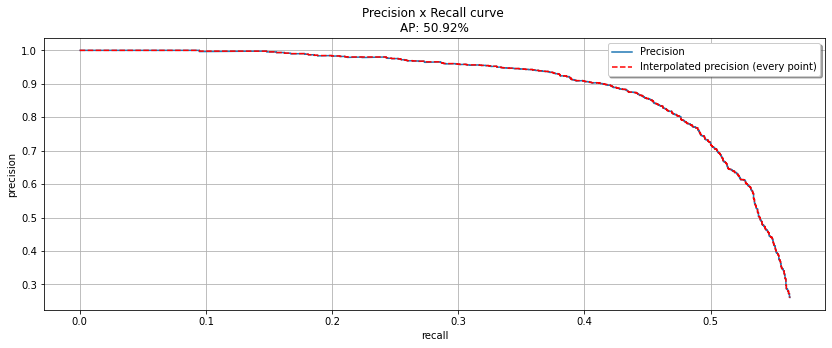


For the adversarial samples : 
Average Precision: 0.07 Total Recall: 0.19


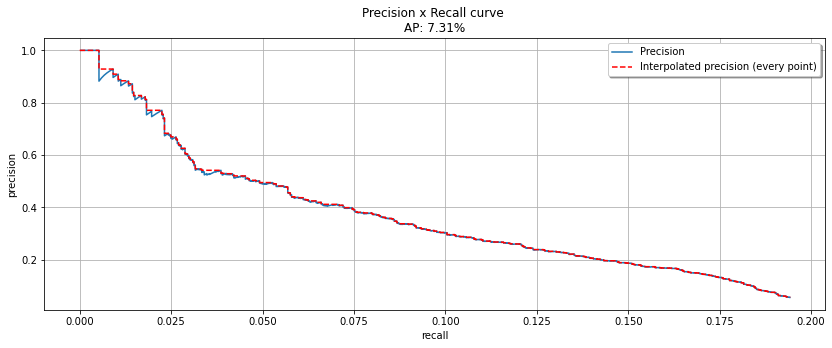

In [30]:
prec = r_original['total TP']/(r_original['total TP'] + r_original['total FP'])
rec = r_original['total TP']/r_original['total positives']
print(f"For the original samples : \nAverage Precision: {r_original['AP']:.2f} Total Recall: {rec:.2f}")
PlotPrecisionRecallCurve(r_original)
print()
prec = r_adversarial_samples['total TP']/(r_adversarial_samples['total TP'] + r_adversarial_samples['total FP'])
rec = r_adversarial_samples['total TP']/r_adversarial_samples['total positives']
print(f"For the adversarial samples : \nAverage Precision: {r_adversarial_samples['AP']:.2f} Total Recall: {rec:.2f}")
PlotPrecisionRecallCurve(r_adversarial_samples)
print()